In [28]:
import cv2
import numpy as np
import torch
from generate_mask_only import gen_mask_only
from IPython.display import display
from PIL import Image
from pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from t_diffusers.unet_2d_condition import UNet2DConditionModel
from diffusers import DDPMScheduler
from hi_sam.text_segmentation import make_text_segmentation_args
import re
import os
import sys
#sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'eval')))
from eval.clipscore.clipscore import cal_clip_score
from eval.fid.src.pytorch_fid.fid_score import cal_fid
from eval.ocr import ocr_eval

td_ckpt = "textdiffuser-ckpt/diffusion_backbone_1.5"
unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    torch_dtype=torch.float32,
)
pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
    ],
    weight_name=[
        "ip-adapter_sd15.safetensors",
    ],
)

pipe.set_ip_adapter_scale(0.4)
input_image_sample = Image.open("./assets/original_input_2.jpeg").convert("RGB").resize((512, 512))

""" Change the text in the original image by coordinates and  """

sample_text_sample="bear"
# for original_input.jpeg. 110, 500에서 가장 가까운 mask의 글자를 바꾼다.
coordinates_sample=[[110, 500]] 

arg_textseg = make_text_segmentation_args(
    model_type='vit_h',
    checkpoint_path='sam_tss_h_textseg.pth',
    input_size=(512, 512),
    hier_det=False,
)

arg_maskgen = make_text_segmentation_args(
    model_type='vit_h',
    checkpoint_path='word_detection_totaltext.pth',
    input_size=(512, 512),
    hier_det=True,
)

/root/anaconda3/envs/textdiff/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.32it/s]


In [41]:
def generating(input_image,caption,coordinates):
    
    
    #input_image_sample = Image.open("./assets/original_input_2.jpeg").convert("RGB").resize((512, 512))
    #coordinates_sample=[[110, 500]] 
    #caption_sample="a scene text signboard with 'cat' on it"

    input_image=input_image.convert("RGB").resize((512,512))
    match = re.search(r"'(.*?)'", caption)    
    item = match.group(1)
    sample_text=item
    print(f"Sample Text is {sample_text}")
    print("\n")
    out = gen_mask_only(input_image, sample_text=sample_text, choice_list=coordinates, arg_textseg=arg_textseg, arg_maskgen=arg_maskgen)
    #out.save(f"./assets/mask_1_out.png") # for debugging
    text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
    captions=[caption]
    pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
    generator = torch.Generator(device="cuda").manual_seed(42)
    pipe.to("cuda")
    
    output = pipe(
        prompt=captions[0],
        input_image=input_image,
        text_mask_image=text_mask_image,
        ip_adapter_image = input_image,
        width=512,
        height=512,
        guidance_scale=7,
        generator=generator,
    ).images[0]
    
    return output

In [46]:
def print_clip_score_ocr_score_fid_score(input,caption,target):
    #clip, lev distance from ocr
     
    #input is output from generating 
    #captions is list and length is one, it has only one sentence
    output=np.array(input)
    output=torch.from_numpy(output)
    output=output.unsqueeze(0)
    output=np.array(output)
    #output=np.unsqueeze(output.unsqueeze(0) # 1 512 512 3 
    captions=[caption]
    clip_score=cal_clip_score(output,captions)
    
    print("CLIP SCORE")
    print(clip_score)
    print("\n")

    ocr_score=ocr_eval(output,captions[0])
    print("OCR SCORE")
    print("\n")
    print("ocr_em_counter, 대문자 소문자 구별")
    print(ocr_score[0])
    print("ocr_em_counter, 대문자 소문자 구별안함")
    print(ocr_score[1])
    print("ocr lev")
    print(ocr_score[2])
    
    input=np.array(input)
    input=torch.from_numpy(input)
    input=input.unsqueeze(0)
    input=np.array(input)
    
    target=np.array(target)
    target=torch.from_numpy(target)
    target=target.unsqueeze(0)
    target=np.array(target)
    print("\n")
    fid_score=cal_fid(input,target)
    print("FID")
    print(fid_score)
    print("\n")
    
    

In [33]:
from datasets import load_dataset
import requests 
def get_one_image_and_caption(number):
    dataset = load_dataset("GoGiants1/TMDBEval500")
    img=dataset["train"][number]["image"]
    link ="https://huggingface.co/datasets/GoGiants1/TMDBEval500/resolve/main/TMDBEval500/TMDBEval500.txt"
    
    caption_link=requests.get(link)
    captions=caption_link.text
    lines=captions.splitlines()
    cap_list=[]
    for index,line in enumerate(lines):
        if index==number:
            cap_list.append(line)
            break
        
    
    return img,cap_list[0]

In [42]:
img,caption=get_one_image_and_caption(0)
coordinates_sample=[[110, 500]] 

out=generating(img,caption,coordinates_sample)


Sample Text is Homeless Hare


Freeze image encoder.
<All keys matched successfully>
Freeze image encoder.
<All keys matched successfully>


/root/anaconda3/envs/textdiff/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/root/anaconda3/envs/textdiff/lib/python3.10/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 4/4 [00:00<00:00,  6.32it/s]


Mask shape:  (512, 512)
latent shape torch.Size([1, 4, 64, 64])
prompt_embeds shape or enc hidden state torch.Size([2, 77, 768])
feature_mask shape torch.Size([1, 1, 64, 64])
masked_feature shape torch.Size([1, 4, 64, 64])
segmentation_mask shape torch.Size([1, 1, 256, 256])


  0%|          | 0/50 [00:00<?, ?it/s]cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] 

Returning


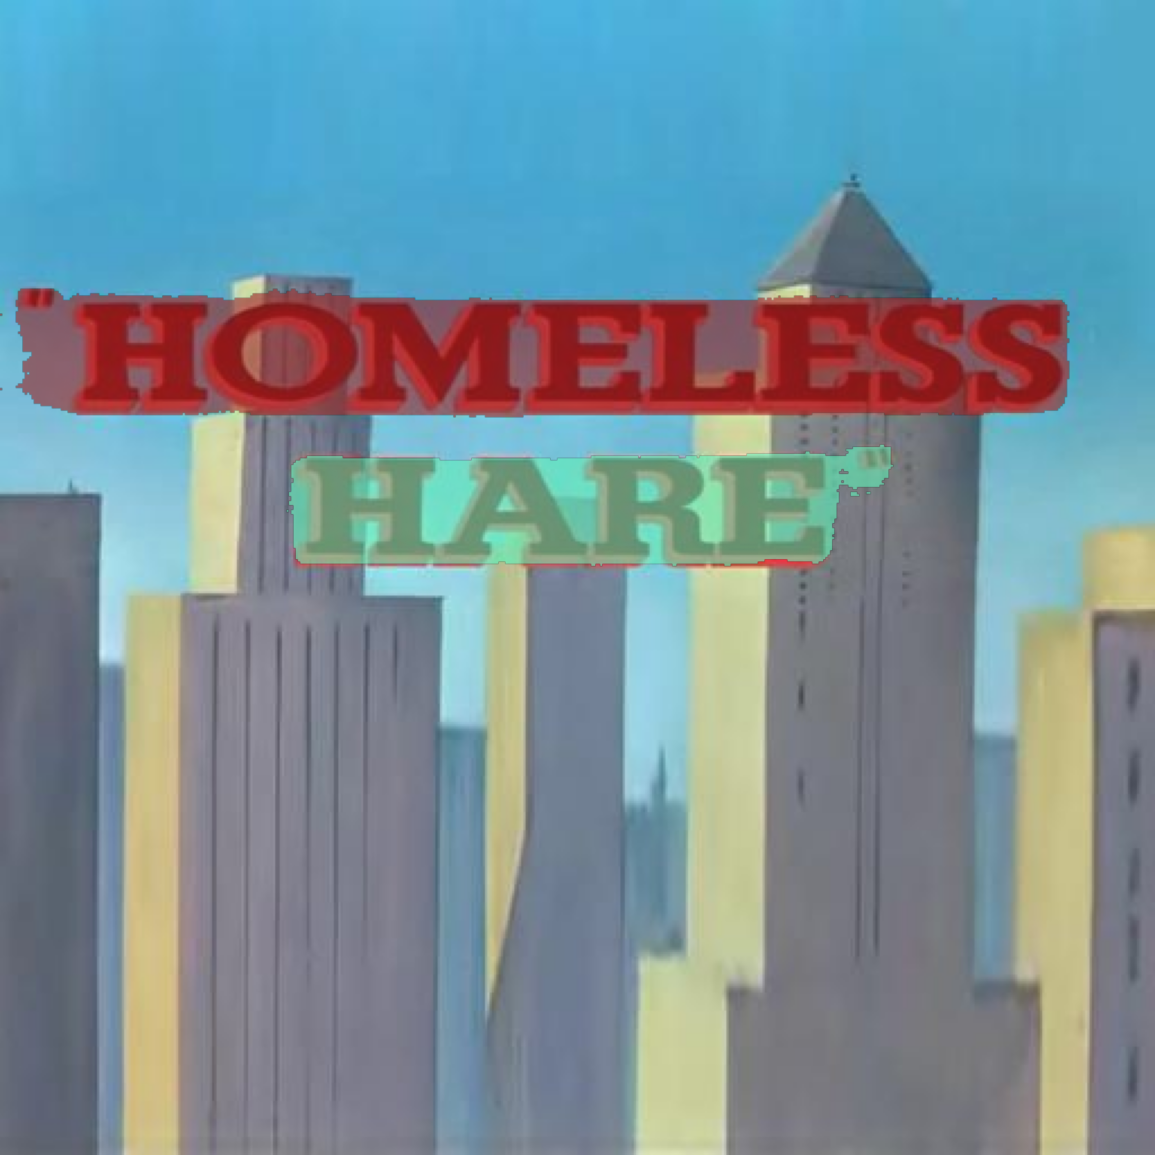

In [48]:
img

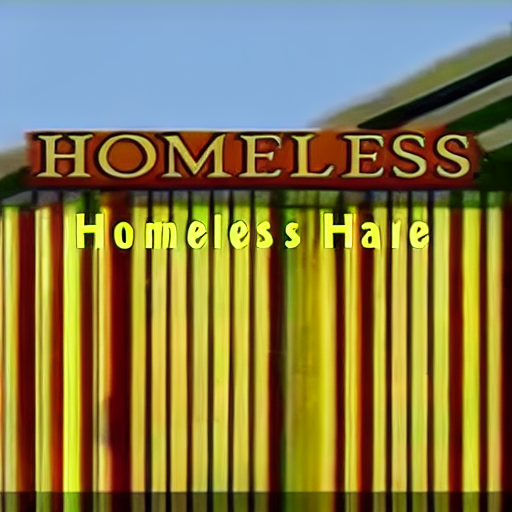

In [43]:
out

In [47]:
print_clip_score_ocr_score_fid_score(out,caption,img)


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]
/root/clip_fid/MLVU-project-main/eval/clipscore/clipscore.py:158: UserWarning: due to a numerical instability, new numpy normalization is slightly different than paper results. to exactly replicate paper results, please use numpy version less than 1.21, e.g., 1.20.3.
  warnings.warn(


CLIP SCORE
0.7158203125


Item is : Homeless Hare
OCR SCORE


ocr_em_counter, 대문자 소문자 구별
0.0
ocr_em_counter, 대문자 소문자 구별안함
0.0
ocr lev
6.0




100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

FID
449.63338376471364




In [ ]:
# def generating(input_image,caption,coordinates):
    
    
#     #input_image_sample = Image.open("./assets/original_input_2.jpeg").convert("RGB").resize((512, 512))
#     #coordinates_sample=[[110, 500]] 
#     #caption_sample="a scene text signboard with 'cat' on it"

#     input_image=input_image.convert("RGB").resize((512,512))
#     match = re.search(r"'(.*?)'", caption)    
#     item = match.group(1)
#     sample_text=item
#     print(f"Sample Text is {sample_text}")
#     print("\n")
#     out = gen_mask_only(input_image, sample_text=sample_text, choice_list=coordinates, arg_textseg=arg_textseg, arg_maskgen=arg_maskgen)
#     #out.save(f"./assets/mask_1_out.png") # for debugging
#     text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
#     captions=[caption]
#     pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
#     generator = torch.Generator(device="cuda").manual_seed(42)
#     pipe.to("cuda")
    
#     output = pipe(
#         prompt=captions[0],
#         input_image=input_image,
#         text_mask_image=text_mask_image,
#         ip_adapter_image = input_image,
#         width=512,
#         height=512,
#         guidance_scale=7,
#         generator=generator,
#     ).images[0]
    
#     return output

# Image to Image

In [1]:
import cv2
import numpy as np
import torch
from generate_mask_only import gen_mask_only
from IPython.display import display
from PIL import Image
from pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from t_diffusers.unet_2d_condition import UNet2DConditionModel

from diffusers import DDPMScheduler
from hi_sam.text_segmentation import make_text_segmentation_args


td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    torch_dtype=torch.float32,
)
pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
    ],
    weight_name=[
        "ip-adapter_sd15.safetensors",
    ],
)
pipe.set_ip_adapter_scale(0.4)


input_image_sample2 = Image.open("./assets/test01.jpeg").convert("RGB").resize((512, 512))


""" Change the text in the original image by coordinates and  """

sample_text_sample2="bear"
# for original_input.jpeg. 110, 500에서 가장 가까운 mask의 글자를 바꾼다.
coordinates_sample2=[[0, 0]] 

arg_textseg = make_text_segmentation_args(
    model_type='vit_l',
    checkpoint_path='sam_tss_l_hiertext.pth',
    input_size=(512, 512),
    hier_det=False,
)

arg_maskgen = make_text_segmentation_args(
    model_type='vit_h',
    checkpoint_path='word_detection_totaltext.pth',
    input_size=(512, 512),
    hier_det=True,
)

def generating2(input_image,caption,coordinates):
    
    
    match = re.search(r"'(.*?)'", caption)    
    item = match.group(1)
    sample_text=item
    
    input_image=input_image.convert("RGB").resize((512, 512))

    out = gen_mask_only(input_image, sample_text=sample_text, choice_list=coordinates, arg_textseg=arg_textseg, arg_maskgen=arg_maskgen)
    # out.save(f"./assets/mask_1_out.png") # for debugging
    text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)

    pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
    generator = torch.Generator(device="cuda").manual_seed(42)
    pipe.to("cuda")
    output = pipe(
        prompt=caption,
        input_image=input_image,
        text_mask_image=text_mask_image,
        ip_adapter_image = input_image,
        width=512,
        height=512,
        guidance_scale=7,
        generator=generator,
    ).images[0]

    return output


2024-05-25 17:33:00.461961: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-25 17:33:00.506858: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 17:33:00.506893: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 17:33:00.506922: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 17:33:00.515687: I tensorflow/core/platform/cpu_feature_g

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Freeze image encoder.
<All keys matched successfully>
Freeze image encoder.
<All keys matched successfully>


/home/s2/mlvu25/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/s2/mlvu25/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Mask shape:  (512, 512)
(512, 512) bool
latent shape torch.Size([1, 4, 64, 64])
prompt_embeds shape or enc hidden state torch.Size([2, 77, 768])
feature_mask shape torch.Size([1, 1, 64, 64])
masked_feature shape torch.Size([1, 4, 64, 64])
segmentation_mask shape torch.Size([1, 1, 256, 256])


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2, 9, 64, 64])
IP-Adapter here!  2 torch.Size([2, 77, 768])
torch.Size([2, 9, 64, 64])
IP-Adapter here!  2 torch.Size([2, 77, 768])
torch.Size([2, 9, 64, 64])
IP-Adapter here!  2 torch.Size([2, 77, 768])
torch.Size([2, 9, 64, 64])
IP-Adapter here!  2 torch.Size([2, 77, 768])
torch.Size([2, 9, 64, 64])
IP-Adapter here!  2 torch.Size([2, 77, 768])
torch.Size([2, 9, 64, 64])
IP-Adapter here!  2 torch.Size([2, 77, 768])
torch.Size([2, 9, 64, 64])
IP-Adapter here!  2 torch.Size([2, 77, 768])
torch.Size([2, 9, 64, 64])
IP-Adapter here!  2 torch.Size([2, 77, 768])
torch.Size([2, 9, 64, 64])
IP-Adapter here!  2 torch.Size([2, 77, 768])
torch.Size([2, 9, 64, 64])
IP-Adapter here!  2 torch.Size([2, 77, 768])
torch.Size([2, 9, 64, 64])
IP-Adapter here!  2 torch.Size([2, 77, 768])
torch.Size([2, 9, 64, 64])
IP-Adapter here!  2 torch.Size([2, 77, 768])
torch.Size([2, 9, 64, 64])
IP-Adapter here!  2 torch.Size([2, 77, 768])
torch.Size([2, 9, 64, 64])
IP-Adapter here!  2 torch.Size([2, 77